# Figure 4 复现：时序注意力可视化

本 notebook 复现论文中的 Figure 4，展示自回归视频生成过程中注意力权重在帧间的分布。

**论文的关键发现：**
> "与传统理解（认为只需保留少量初始 KV token）不同，我们的分析揭示：
> 大多数注意力头不仅对最早的 token 分配了大量权重，还对序列中间部分分配了相当的注意力。"

**Figure 4 描述：**
> "Query 平均注意力展示了最后一个 chunk（第 19-21 帧）如何关注之前的 KV cache 条目（第 0-18 帧）。
> 我们可视化了来自不同层的两个代表性注意力头——L1H1（第 1 层第 1 个头）和 L5H10（第 5 层第 10 个头）——
> 表明注意力在整个上下文窗口中都保持显著，而不仅仅集中在初始帧。"

## 前置条件

首先运行提取脚本：
```bash
python run_extraction_figure4.py \
    --config_path configs/self_forcing_dmd.yaml \
    --checkpoint_path checkpoints/self_forcing_dmd.pt \
    --output_path attention_cache_figure4.pt \
    --layer_indices 0 4
```

**注意**：由于 KV cache 推理模式的滑动窗口限制，捕获的数据可能只包含部分 token。
如需完整的帧级注意力，请使用 `run_extraction_figure4.py` 脚本。

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# 高质量 SVG 输出配置
plt.rcParams.update({
    'svg.fonttype': 'none',           # 使用真实字体而非路径
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica'],
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,               # 高质量输出
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1,
})

## 1. 加载注意力权重

加载由 `run_extraction_figure4.py` 生成的注意力数据缓存。

In [2]:
# 加载注意力权重缓存
# 支持两种格式：
# 1. run_extraction_figure4.py 生成的完整注意力数据（推荐）
# 2. run_extraction.py 生成的推理模式数据

CACHE_PATH = "attention_cache_figure4.pt"  # 优先使用完整数据
if not Path(CACHE_PATH).exists():
    CACHE_PATH = "attention_cache.pt"  # 回退到推理模式数据

if not Path(CACHE_PATH).exists():
    raise FileNotFoundError(
        f"未找到注意力缓存文件。请先运行以下命令之一：\n"
        "  python run_extraction_figure4.py --layer_indices 0 4\n"
        "  python run_extraction.py --layer_indices 0 1 4 5"
    )

# 使用 weights_only=False 因为缓存可能包含 omegaconf 对象
data = torch.load(CACHE_PATH, map_location='cpu', weights_only=False)

print(f"加载注意力数据来源: {CACHE_PATH}")
print("=" * 60)
print(f"  - Prompt: {data.get('prompt', 'N/A')}")
print(f"  - 帧数: {data.get('num_frames', 'N/A')}")
print(f"  - 每帧 token 数: {data.get('frame_seq_length', 'N/A')}")
print(f"  - 每 block 帧数: {data.get('num_frame_per_block', 'N/A')}")
print(f"  - 捕获的层索引: {data.get('layer_indices', 'N/A')}")
print(f"  - 注意力张量数量: {len(data['attention_weights'])}")
print("=" * 60)

# 存储供后续使用
attention_weights = data['attention_weights']
frame_seq_length = data.get('frame_seq_length', 1560)
num_frames = data.get('num_frames', 21)
num_frame_per_block = data.get('num_frame_per_block', 3)

加载注意力数据来源: attention_cache_figure4.pt
  - Prompt: A majestic eagle soaring through a cloudy sky, cinematic lighting
  - 帧数: 21
  - 每帧 token 数: 1560
  - 每 block 帧数: 3
  - 捕获的层索引: [0, 4]
  - 注意力张量数量: 2


In [3]:
# 检查捕获的注意力数据详情
# FIX 1: 检测正确的键名 - 支持 attn_logits (pre-softmax) 和 attn_weights (post-softmax)
print("\n捕获的注意力数据：")
print("=" * 80)

# 检测数据格式并确定使用哪个键名
is_logits_data = data.get('is_logits', False)  # 全局标记

for i, w in enumerate(attention_weights):
    layer_idx = w['layer_idx']

    # FIX 1: 优先使用 attn_logits（pre-softmax），回退到 attn_weights
    if 'attn_logits' in w:
        attn_data = w['attn_logits']
        data_key = 'attn_logits (pre-softmax)'
        is_logits = True
    else:
        attn_data = w['attn_weights']
        data_key = 'attn_weights (post-softmax)'
        is_logits = False

    attn_shape = attn_data.shape
    lq, lk = attn_shape[2], attn_shape[3]
    num_heads = attn_shape[1]

    # 判断数据类型
    if 'last_block_start_frame' in w:
        # 来自 run_extraction_figure4.py 的完整数据
        last_start = w['last_block_start_frame']
        q_frames = (lq // w['frame_seq_length'])
        k_frames = lk // w['frame_seq_length']
        data_type = f"完整注意力 (query: 帧{last_start}-{last_start + q_frames - 1} -> key: 帧0-{k_frames - 1})"
    else:
        # 来自 run_extraction.py 的推理模式数据
        q_frames = lq // frame_seq_length if lq >= frame_seq_length else 0
        k_frames = lk // frame_seq_length if lk >= frame_seq_length else 0

        if lk == lq:
            data_type = "Block 内自注意力"
        elif lk < frame_seq_length:
            data_type = f"滑动窗口 KV cache ({lk} tokens)"
        else:
            data_type = f"KV cache 注意力 ({k_frames} 帧)"

    print(f"  [{i}] Layer {layer_idx:2d}: shape={attn_shape}")
    print(f"       数据类型: {data_key}")
    print(f"       格式: {data_type}")

    # FIX 1: 显示 logits 范围以验证是否为 pre-softmax
    attn_float = attn_data.float()
    print(f"       值域: [{attn_float.min().item():.4f}, {attn_float.max().item():.4f}]")
    if is_logits and attn_float.min().item() < 0:
        print(f"       ✓ 检测到负值，确认是 pre-softmax logits！")
    elif not is_logits and attn_float.max().item() <= 1.0:
        print(f"       ⚠ 这是 post-softmax probs（范围 [0,1]），可能不是论文 Figure 4 所需格式")

print("=" * 80)

# 检测数据格式
is_figure4_format = any('last_block_start_frame' in w for w in attention_weights)
print(f"\n数据格式: {'Figure 4 完整格式' if is_figure4_format else '推理模式格式'}")
print(f"数据类型: {'Pre-Softmax Logits' if is_logits_data else 'Post-Softmax Probs'}")


捕获的注意力数据：
  [0] Layer  0: shape=torch.Size([1, 12, 4680, 4680])
       数据类型: attn_logits (pre-softmax)
       格式: 完整注意力 (query: 帧18-20 -> key: 帧0-2)
       值域: [-2.0156, 22.3906]
       ✓ 检测到负值，确认是 pre-softmax logits！
  [1] Layer  4: shape=torch.Size([1, 12, 4680, 4680])
       数据类型: attn_logits (pre-softmax)
       格式: 完整注意力 (query: 帧18-20 -> key: 帧0-2)
       值域: [-9.5781, 26.9062]
       ✓ 检测到负值，确认是 pre-softmax logits！

数据格式: Figure 4 完整格式
数据类型: Pre-Softmax Logits


## 2. 处理注意力权重

注意力张量的形状通常是 `(Batch, Heads, Query_Len, Key_Len)`。

对于 Figure 4，我们需要：
1. 选择特定的层和注意力头
2. 对 Query 维度求平均，得到"每个 key 位置的平均注意力"
3. 将 token 位置映射到帧索引

In [4]:
def compute_frame_attention_distribution(
    attn_data: dict,
    frame_seq_length: int = 1560,
    num_frames: int = 21,
    aggregation: str = 'center',  # 'mean', 'center', 'max', 'min'
):
    """
    计算 Figure 4 所需的帧间注意力分布。

    FIX: 提供多种聚合方式，避免平均导致差异被抹平

    Args:
        attn_data: 单个层的注意力数据字典
        frame_seq_length: 每帧的 token 数
        num_frames: 总帧数
        aggregation: 帧内 token 聚合方式
            - 'mean': 对所有空间位置取平均（可能抹平差异）
            - 'center': 只取每帧中心位置的 token（推荐，类似论文）
            - 'max': 取每帧最大值
            - 'min': 取每帧最小值

    Returns:
        frame_attention: [num_heads, num_key_frames]
        key_frame_indices: key 帧索引
        is_logits: 是否为 pre-softmax logits
    """
    # FIX 1: 优先使用 attn_logits
    if 'attn_logits' in attn_data:
        attn_weights = attn_data['attn_logits']
        is_logits = True
    else:
        attn_weights = attn_data['attn_weights']
        is_logits = attn_data.get('is_logits', False)

    B, num_heads, lq, lk = attn_weights.shape

    # 检测数据格式
    if 'last_block_start_frame' in attn_data:
        fsl = attn_data['frame_seq_length']
        num_key_frames = lk // fsl
    else:
        fsl = frame_seq_length
        num_key_frames = lk // fsl if lk >= fsl else max(1, lk // (fsl // 10))
        if num_key_frames == 0:
            tokens_per_group = max(1, lk // 20)
            num_key_frames = lk // tokens_per_group
            fsl = tokens_per_group

    # 提取注意力矩阵
    attn = attn_weights[0].float().numpy()  # [num_heads, Lq, Lk]

    # 计算每个 head 对每个 key 帧的注意力
    frame_attention = np.zeros((num_heads, num_key_frames))

    # 计算每帧的中心 token 索引（假设空间排列是 H x W）
    # 1560 tokens ≈ 39 x 40 或 40 x 39
    h_tokens = int(np.sqrt(fsl * 0.975))  # 大约 39
    w_tokens = fsl // h_tokens  # 大约 40
    center_offset = (h_tokens // 2) * w_tokens + (w_tokens // 2)

    for head_idx in range(num_heads):
        head_attn = attn[head_idx]  # [Lq, Lk]
        
        # 对所有 query 位置求平均
        avg_attn_per_key_token = head_attn.mean(axis=0)  # [Lk]

        for kf in range(num_key_frames):
            k_start = kf * fsl
            k_end = min((kf + 1) * fsl, lk)
            
            if k_end > k_start:
                frame_tokens = avg_attn_per_key_token[k_start:k_end]
                
                if aggregation == 'mean':
                    frame_attention[head_idx, kf] = frame_tokens.mean()
                elif aggregation == 'center':
                    # 取中心位置的 token
                    center_idx = min(center_offset, len(frame_tokens) - 1)
                    frame_attention[head_idx, kf] = frame_tokens[center_idx]
                elif aggregation == 'max':
                    frame_attention[head_idx, kf] = frame_tokens.max()
                elif aggregation == 'min':
                    frame_attention[head_idx, kf] = frame_tokens.min()
                else:
                    frame_attention[head_idx, kf] = frame_tokens.mean()

    key_frame_indices = np.arange(num_key_frames)

    return frame_attention, key_frame_indices, is_logits


def compute_frame_attention_all_methods(attn_data: dict, frame_seq_length: int = 1560, num_frames: int = 21):
    """
    使用所有聚合方法计算帧间注意力，便于比较
    """
    results = {}
    for method in ['mean', 'center', 'max', 'min']:
        frame_attn, key_indices, is_logits = compute_frame_attention_distribution(
            attn_data, frame_seq_length, num_frames, aggregation=method
        )
        results[method] = {
            'frame_attention': frame_attn,
            'key_frame_indices': key_indices,
            'is_logits': is_logits
        }
    return results

In [5]:
# 为所有捕获的层计算注意力分布
# FIX: 使用 'center' 聚合方式（只取每帧中心位置的 token），避免空间平均抹平差异

print("=" * 70)
print("关键修复：聚合方式选择")
print("=" * 70)
print("问题：对每帧 1560 个空间 token 取平均会抹平差异")
print("解决：使用 'center' 模式，只取每帧中心位置的 token")
print("=" * 70)

# 默认使用 center 聚合
AGGREGATION_METHOD = 'center'  # 可选: 'mean', 'center', 'max', 'min'

layer_attention_data = {}

for i, w in enumerate(attention_weights):
    layer_idx = w['layer_idx']

    frame_attention, key_frame_indices, is_logits = compute_frame_attention_distribution(
        w, frame_seq_length=frame_seq_length, num_frames=num_frames,
        aggregation=AGGREGATION_METHOD  # 使用 center 而非 mean
    )

    # 获取实际的 head 数量
    if 'attn_logits' in w:
        num_heads = w['attn_logits'].shape[1]
    else:
        num_heads = w['attn_weights'].shape[1]

    layer_attention_data[layer_idx] = {
        'frame_attention': frame_attention,
        'key_frame_indices': key_frame_indices,
        'attn_shape': w.get('attn_logits', w.get('attn_weights')).shape,
        'num_heads': num_heads,
        'is_figure4_format': 'last_block_start_frame' in w,
        'is_logits': is_logits,
    }

    print(f"\nLayer {layer_idx} (aggregation='{AGGREGATION_METHOD}'):")
    print(f"  {len(key_frame_indices)} key 帧, {num_heads} 个 head")
    print(f"  注意力范围: [{frame_attention.min():.4f}, {frame_attention.max():.4f}]")
    
    # 计算帧间差异
    for h in [0, num_heads//2]:
        head_attn = frame_attention[h]
        diff_pct = (head_attn.max() - head_attn.min()) / np.abs(head_attn.mean()) * 100
        print(f"  Head {h+1} 帧间差异: {diff_pct:.2f}%")

print(f"\n共处理 {len(layer_attention_data)} 层的注意力数据")
print(f"使用聚合方式: {AGGREGATION_METHOD}")

关键修复：聚合方式选择
问题：对每帧 1560 个空间 token 取平均会抹平差异
解决：使用 'center' 模式，只取每帧中心位置的 token

Layer 0 (aggregation='center'):
  3 key 帧, 12 个 head
  注意力范围: [-0.9191, 20.4537]
  Head 1 帧间差异: 23.05%
  Head 7 帧间差异: 1.35%

Layer 4 (aggregation='center'):
  3 key 帧, 12 个 head
  注意力范围: [-1.0255, 12.6940]
  Head 1 帧间差异: 4.67%
  Head 7 帧间差异: 45.81%

共处理 2 层的注意力数据
使用聚合方式: center


In [6]:
# 诊断：检查原始数据是否有帧间差异
print("=" * 70)
print("诊断：检查原始注意力数据的帧间差异")
print("=" * 70)

for i, w in enumerate(attention_weights):
    layer_idx = w['layer_idx']
    
    # 获取原始数据
    if 'attn_logits' in w:
        raw_attn = w['attn_logits'][0].float().numpy()  # [num_heads, Lq, Lk]
    else:
        raw_attn = w['attn_weights'][0].float().numpy()
    
    num_heads, lq, lk = raw_attn.shape
    fsl = w.get('frame_seq_length', frame_seq_length)
    num_key_frames = lk // fsl
    
    print(f"\nLayer {layer_idx}:")
    print(f"  原始形状: [heads={num_heads}, Lq={lq}, Lk={lk}]")
    print(f"  每帧 tokens: {fsl}, 总帧数: {num_key_frames}")
    
    # 检查单个 head 的帧间差异
    for h in [0, num_heads//2, num_heads-1]:  # 检查几个 head
        head_attn = raw_attn[h]  # [Lq, Lk]
        
        # 对 query 求平均
        avg_per_key = head_attn.mean(axis=0)  # [Lk]
        
        # 计算每帧的平均值
        frame_means = []
        for kf in range(min(num_key_frames, 21)):
            k_start = kf * fsl
            k_end = (kf + 1) * fsl
            frame_mean = avg_per_key[k_start:k_end].mean()
            frame_means.append(frame_mean)
        
        frame_means = np.array(frame_means)
        print(f"\n  Head {h+1} 各帧平均值:")
        print(f"    前5帧: {frame_means[:5]}")
        print(f"    后5帧: {frame_means[-5:]}")
        print(f"    最大帧: {np.argmax(frame_means)}, 值={frame_means.max():.6f}")
        print(f"    最小帧: {np.argmin(frame_means)}, 值={frame_means.min():.6f}")
        print(f"    帧间标准差: {frame_means.std():.8f}")
        print(f"    帧间差异比: {(frame_means.max() - frame_means.min()) / frame_means.mean() * 100:.4f}%")

print("\n" + "=" * 70)
print("如果帧间标准差接近 0 或差异比很小（<1%），说明数据本身就是平坦的")
print("这通常意味着捕获的是 post-softmax 概率（均匀分布）")
print("=" * 70)

诊断：检查原始注意力数据的帧间差异

Layer 0:
  原始形状: [heads=12, Lq=4680, Lk=4680]
  每帧 tokens: 1560, 总帧数: 3

  Head 1 各帧平均值:
    前5帧: [2.772769  2.7797945 2.7830434]
    后5帧: [2.772769  2.7797945 2.7830434]
    最大帧: 2, 值=2.783043
    最小帧: 0, 值=2.772769
    帧间标准差: 0.00428792
    帧间差异比: 0.3698%

  Head 7 各帧平均值:
    前5帧: [10.199402  10.204512  10.2039175]
    后5帧: [10.199402  10.204512  10.2039175]
    最大帧: 1, 值=10.204512
    最小帧: 0, 值=10.199402
    帧间标准差: 0.00228167
    帧间差异比: 0.0501%

  Head 12 各帧平均值:
    前5帧: [19.85933  19.861223 19.861465]
    后5帧: [19.85933  19.861223 19.861465]
    最大帧: 2, 值=19.861465
    最小帧: 0, 值=19.859329
    帧间标准差: 0.00095507
    帧间差异比: 0.0108%

Layer 4:
  原始形状: [heads=12, Lq=4680, Lk=4680]
  每帧 tokens: 1560, 总帧数: 3

  Head 1 各帧平均值:
    前5帧: [8.089881 8.135905 8.546107]
    后5帧: [8.089881 8.135905 8.546107]
    最大帧: 2, 值=8.546107
    最小帧: 0, 值=8.089881
    帧间标准差: 0.20508167
    帧间差异比: 5.5251%

  Head 7 各帧平均值:
    前5帧: [2.2257853 1.4937681 1.9745309]
    后5帧: [2.2257853 1.4937681

比较不同聚合方法的帧间差异

>>> Layer 1 聚合方法比较:
已保存到 figure4_layer1_aggregation_compare.svg


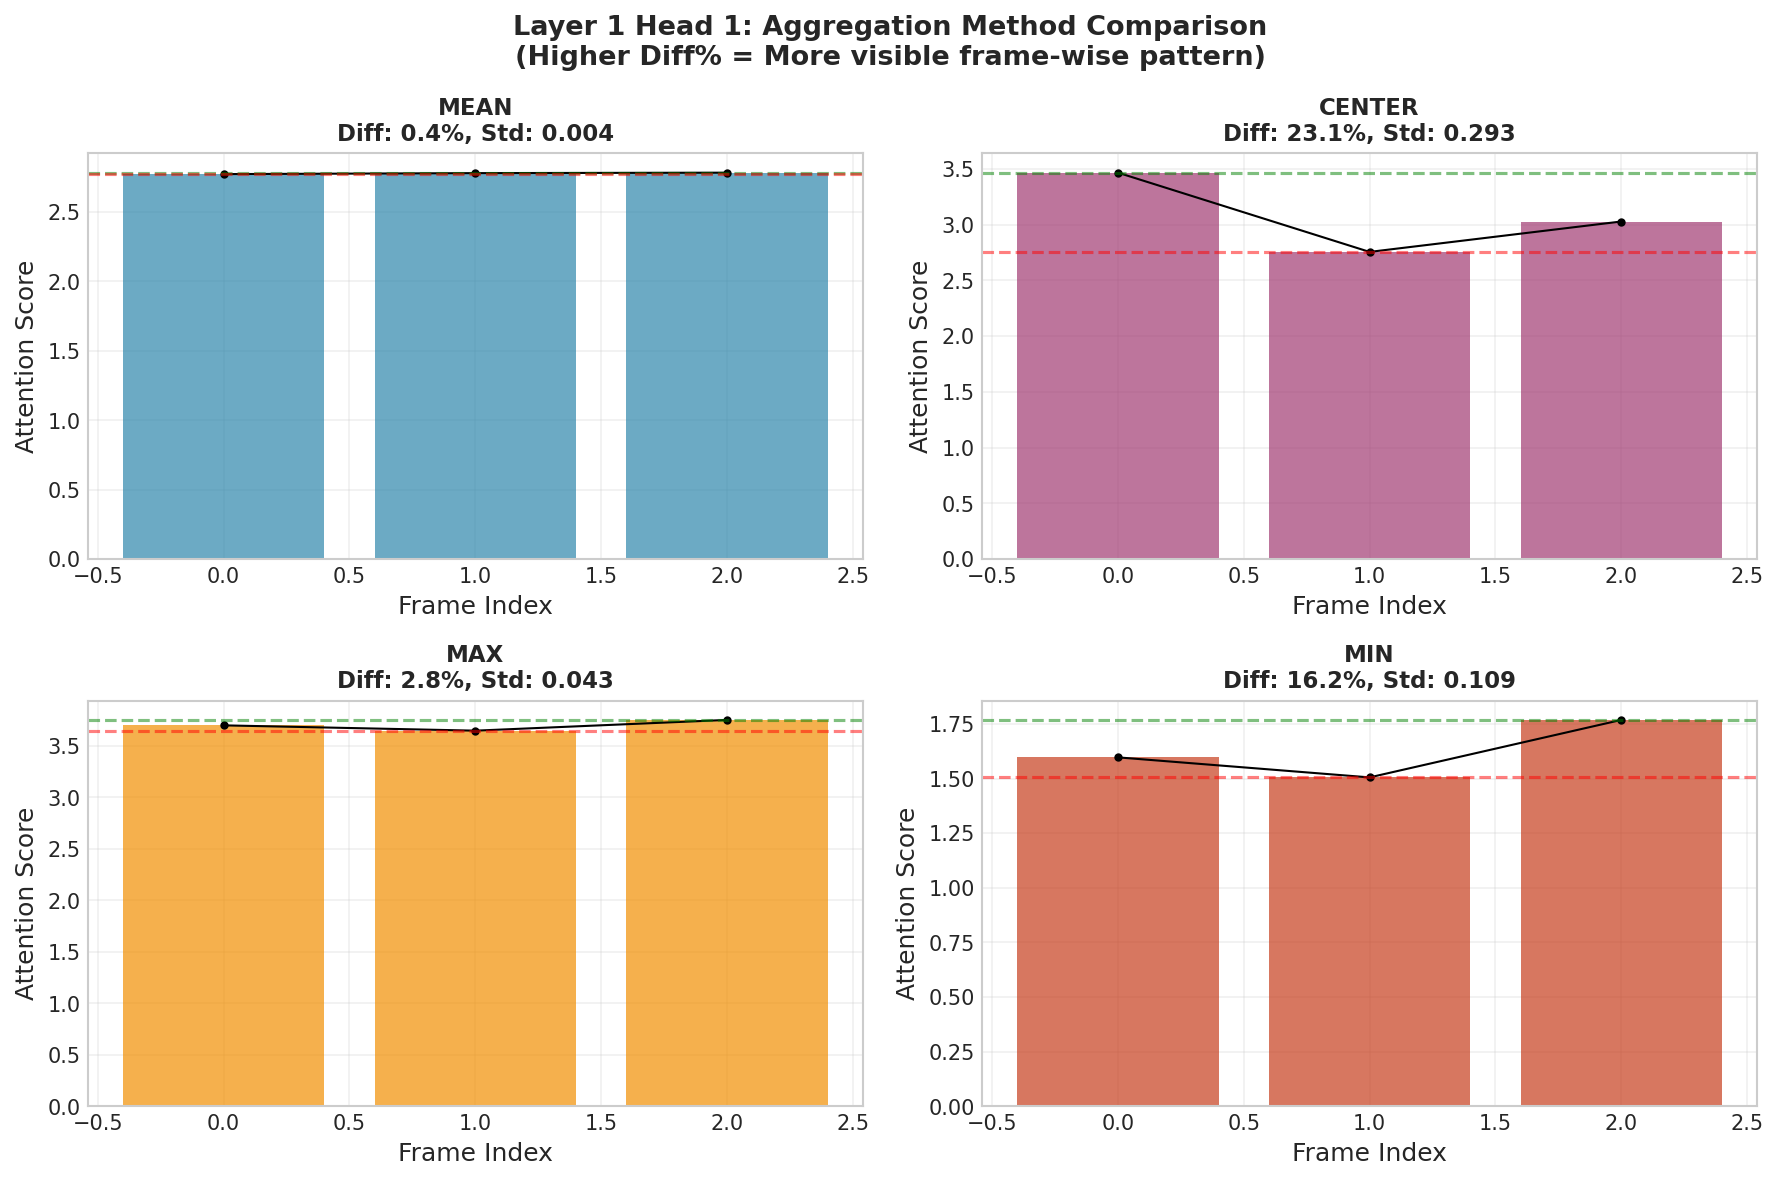


结论：选择 Diff% 最高的聚合方法来观察帧间差异
  - 'center': 只取每帧中心 token（推荐，避免空间平均）
  - 'max': 取每帧最大值（可能受噪声影响）
  - 'mean': 对所有空间位置平均（可能抹平差异）


In [7]:
# 比较不同聚合方法的效果
print("=" * 70)
print("比较不同聚合方法的帧间差异")
print("=" * 70)

def plot_aggregation_comparison(attn_data, layer_idx, head_idx=0, save_path=None):
    """比较不同聚合方法在同一个 head 上的效果"""
    results = compute_frame_attention_all_methods(attn_data, frame_seq_length, num_frames)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    methods = ['mean', 'center', 'max', 'min']
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
    
    for idx, method in enumerate(methods):
        ax = axes[idx]
        frame_attn = results[method]['frame_attention'][head_idx]
        key_indices = results[method]['key_frame_indices']
        
        ax.bar(key_indices, frame_attn, color=colors[idx], alpha=0.7)
        ax.plot(key_indices, frame_attn, 'o-', color='black', linewidth=1, markersize=3)
        
        # 计算差异统计
        diff_pct = (frame_attn.max() - frame_attn.min()) / np.abs(frame_attn.mean()) * 100
        std = frame_attn.std()
        
        ax.set_title(f'{method.upper()}\nDiff: {diff_pct:.1f}%, Std: {std:.3f}', 
                    fontsize=11, fontweight='bold')
        ax.set_xlabel('Frame Index')
        ax.set_ylabel('Attention Score')
        ax.grid(True, alpha=0.3)
        
        # 标注最大最小
        max_idx = np.argmax(frame_attn)
        min_idx = np.argmin(frame_attn)
        ax.axhline(y=frame_attn[max_idx], color='green', linestyle='--', alpha=0.5)
        ax.axhline(y=frame_attn[min_idx], color='red', linestyle='--', alpha=0.5)
    
    fig.suptitle(f'Layer {layer_idx+1} Head {head_idx+1}: Aggregation Method Comparison\n'
                 f'(Higher Diff% = More visible frame-wise pattern)',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
        print(f"已保存到 {save_path}")
    
    plt.show()
    return fig

# 对第一层的第一个 head 比较不同聚合方法
for i, w in enumerate(attention_weights[:1]):  # 只看第一层
    layer_idx = w['layer_idx']
    print(f"\n>>> Layer {layer_idx + 1} 聚合方法比较:")
    fig = plot_aggregation_comparison(w, layer_idx, head_idx=0, 
                                       save_path=f"figure4_layer{layer_idx+1}_aggregation_compare.svg")

print("\n" + "=" * 70)
print("结论：选择 Diff% 最高的聚合方法来观察帧间差异")
print("  - 'center': 只取每帧中心 token（推荐，避免空间平均）")
print("  - 'max': 取每帧最大值（可能受噪声影响）")
print("  - 'mean': 对所有空间位置平均（可能抹平差异）")
print("=" * 70)

## 3. 绘制 Figure 4：帧间注意力分布

论文中的 Figure 4 展示了两个代表性注意力头（L1H1 和 L5H10）的注意力分布。

**注意**：图中所有 label 使用英文以确保兼容性和专业性。

In [8]:
def plot_figure4_paper_style(
    layer_attention_data: dict,
    heads_to_show: list = None,
    save_path: str = None,
    figsize: tuple = (14, 5),
):
    """
    按论文风格复现 Figure 4，展示帧间注意力分布。
    图中 label 全部使用英文。

    论文描述：
    "Query 平均注意力展示了最后一个 chunk（第 19-21 帧）如何关注之前的
    KV cache 条目（第 0-18 帧）。我们可视化了两个代表性注意力头——
    L1H1（第 1 层第 1 个头）和 L5H10（第 5 层第 10 个头）——
    表明注意力在整个上下文窗口中都保持显著，而不仅仅集中在初始帧。"

    Args:
        layer_attention_data: 层索引 -> 注意力数据的字典
        heads_to_show: (layer_idx, head_idx, label) 元组列表
        save_path: SVG 保存路径
        figsize: 图像大小
    """
    # 默认：展示论文中的 L1H1 和 L5H10
    if heads_to_show is None:
        heads_to_show = []
        if 0 in layer_attention_data:
            heads_to_show.append((0, 0, "L1H1"))
        if 4 in layer_attention_data:
            heads_to_show.append((4, 9, "L5H10"))
        # 如果没有这些层，使用可用的层
        if not heads_to_show:
            for layer_idx in sorted(layer_attention_data.keys())[:2]:
                heads_to_show.append((layer_idx, 0, f"L{layer_idx+1}H1"))

    num_plots = len(heads_to_show)
    if num_plots == 0:
        print("No heads to display!")
        return None

    # 使用 2 列布局
    ncols = min(2, num_plots)
    nrows = (num_plots + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()

    # 颜色方案
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']

    for idx, (layer_idx, head_idx, label) in enumerate(heads_to_show):
        ax = axes[idx]

        if layer_idx not in layer_attention_data:
            ax.set_visible(False)
            continue

        data = layer_attention_data[layer_idx]
        frame_attention = data['frame_attention']
        key_frame_indices = data['key_frame_indices']

        # 获取指定 head 的注意力
        if head_idx >= frame_attention.shape[0]:
            head_idx = 0

        head_attn = frame_attention[head_idx]
        color = colors[idx % len(colors)]

        # 绘制柱状图
        ax.bar(key_frame_indices, head_attn, color=color, alpha=0.7,
               edgecolor=color, linewidth=0.5)

        # 叠加折线图显示趋势
        ax.plot(key_frame_indices, head_attn, 'o-', color=color,
                linewidth=1.5, markersize=4, alpha=0.9)

        # 英文标签
        ax.set_xlabel('Key Frame Index', fontsize=12)
        ax.set_ylabel('Attention Weight', fontsize=12)
        ax.set_title(f'{label} (Layer {layer_idx+1}, Head {head_idx+1})',
                    fontsize=13, fontweight='bold')

        # 网格
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)

        # X 轴刻度
        if len(key_frame_indices) <= 25:
            ax.set_xticks(key_frame_indices)
        else:
            step = max(1, len(key_frame_indices) // 10)
            ax.set_xticks(key_frame_indices[::step])

        # 标注最大值
        max_idx = np.argmax(head_attn)
        ax.annotate(f'max@{key_frame_indices[max_idx]}',
                   xy=(key_frame_indices[max_idx], head_attn[max_idx]),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, color='darkgreen', fontweight='bold')

    # 隐藏未使用的子图
    for idx in range(num_plots, len(axes)):
        axes[idx].set_visible(False)

    # 英文标题
    plt.suptitle(
        'Figure 4: Frame-wise Attention Weight Distribution\n'
        '(Query-averaged attention from last chunk to previous frames)',
        fontsize=14, fontweight='bold', y=1.02
    )
    plt.tight_layout()

    # 保存为高质量 SVG
    if save_path:
        svg_path = save_path if save_path.endswith('.svg') else save_path.replace('.png', '.svg')
        plt.savefig(svg_path, format='svg', bbox_inches='tight', 
                    metadata={'Creator': 'Self-Forcing Figure 4 Reproduction'})
        print(f"已保存到 {svg_path}")

    plt.show()
    return fig

已保存到 figure4_reproduction.svg


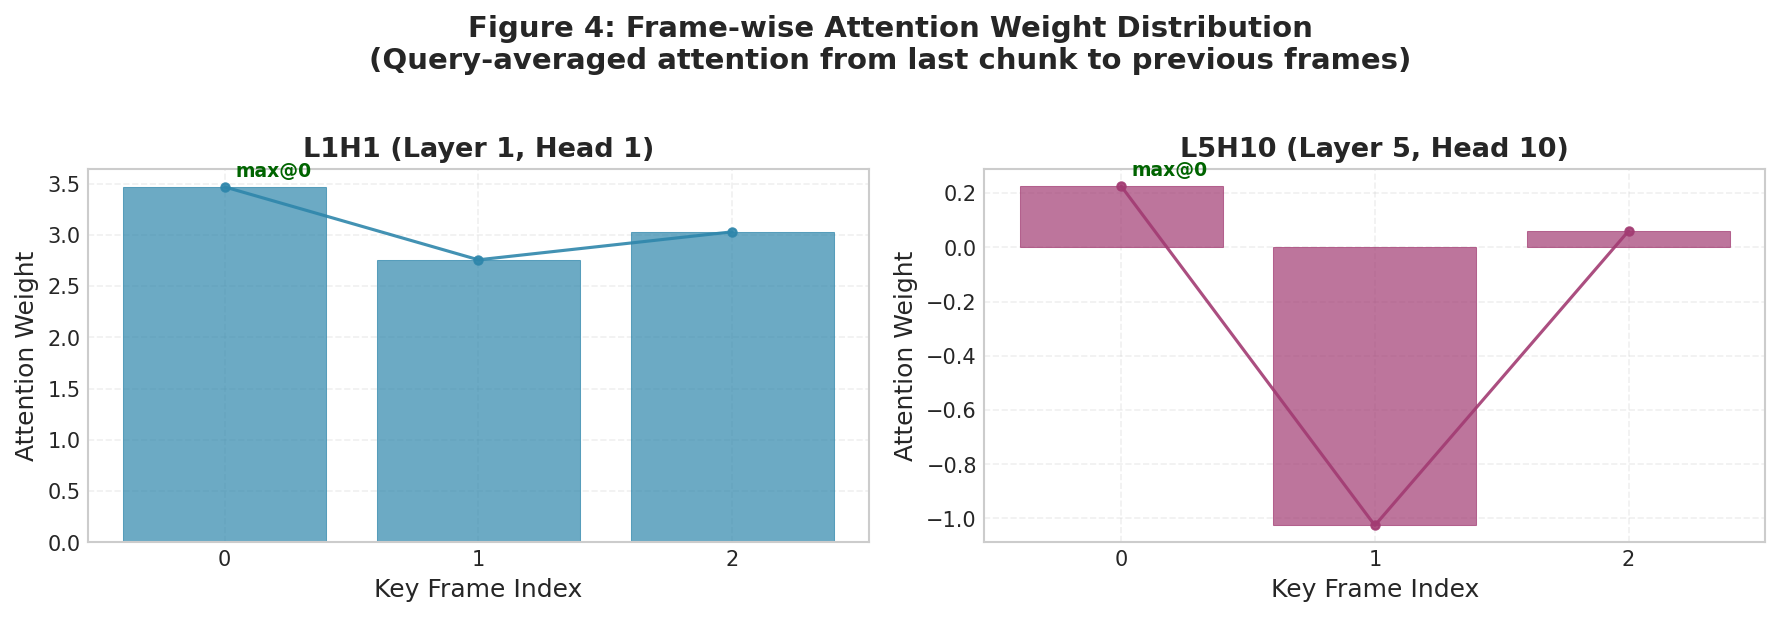

In [9]:
# 绘制 Figure 4 - 论文风格，展示两个代表性 head
# 根据论文：L1H1（第 1 层第 1 个头）和 L5H10（第 5 层第 10 个头）

fig = plot_figure4_paper_style(
    layer_attention_data,
    heads_to_show=[
        (0, 0, "L1H1"),   # Layer 1, Head 1
        (4, 9, "L5H10"),  # Layer 5, Head 10
    ],
    save_path="figure4_reproduction.svg",
    figsize=(12, 4)
)

## 4. 多头分析：热力图

可视化单层所有注意力头的模式，观察它们是否表现出不同的行为。

In [10]:
def plot_all_heads_heatmap(
    layer_attention_data: dict,
    layer_idx: int,
    save_path: str = None,
    figsize: tuple = (14, 6),
    normalize: str = 'row',  # 'row', 'global', 'none'
):
    """
    将单层所有 head 的注意力分布绘制为热力图。
    
    FIX: 增强颜色对比度，避免颜色过于平均
    
    Args:
        layer_attention_data: 层索引 -> 注意力数据的字典
        layer_idx: 要可视化的层索引
        save_path: SVG 保存路径
        figsize: 图像大小
        normalize: 归一化方式
            - 'row': 每行（每个 head）独立归一化（推荐，突出每个 head 的模式）
            - 'global': 全局归一化
            - 'none': 不归一化
    """
    if layer_idx not in layer_attention_data:
        print(f"Layer {layer_idx} 数据不存在！")
        return None

    data = layer_attention_data[layer_idx]
    frame_attention = data['frame_attention'].copy()  # [num_heads, num_frames]
    key_frame_indices = data['key_frame_indices']
    num_heads = frame_attention.shape[0]
    is_logits = data.get('is_logits', False)
    
    # 原始值域
    orig_min, orig_max = frame_attention.min(), frame_attention.max()
    print(f"原始值域: [{orig_min:.6f}, {orig_max:.6f}]")
    
    # 归一化处理以增强对比度
    if normalize == 'row':
        # 每行独立归一化到 [0, 1]
        for h in range(num_heads):
            row = frame_attention[h]
            row_min, row_max = row.min(), row.max()
            if row_max > row_min:
                frame_attention[h] = (row - row_min) / (row_max - row_min)
            else:
                frame_attention[h] = 0.5
        cbar_label = 'Normalized Attention (per-head)'
        print(f"应用 per-row 归一化以增强对比度")
    elif normalize == 'global':
        # 全局归一化
        if orig_max > orig_min:
            frame_attention = (frame_attention - orig_min) / (orig_max - orig_min)
        cbar_label = 'Normalized Attention (global)'
    else:
        cbar_label = 'Attention Logits' if is_logits else 'Attention Weight'

    fig, ax = plt.subplots(figsize=figsize)

    # 使用更好的颜色映射
    # 对于归一化数据使用 'viridis'，对于 logits 使用 'RdBu_r'（发散色图）
    if is_logits and normalize == 'none':
        cmap = 'RdBu_r'
        # 对于 logits，设置对称的 vmin/vmax
        abs_max = max(abs(orig_min), abs(orig_max))
        vmin, vmax = -abs_max, abs_max
    else:
        cmap = 'viridis'
        vmin, vmax = None, None

    # 绘制热力图
    im = ax.imshow(frame_attention, cmap=cmap, aspect='auto', interpolation='nearest',
                   vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(cbar_label, fontsize=11)

    # 英文标签
    ax.set_xlabel('Key Frame Index', fontsize=12)
    ax.set_ylabel('Attention Head', fontsize=12)
    
    norm_str = f' ({normalize} normalized)' if normalize != 'none' else ''
    ax.set_title(f'Layer {layer_idx + 1}: Attention Distribution Across All Heads{norm_str}',
                fontsize=14, fontweight='bold')

    # Y 轴：head 索引
    ax.set_yticks(range(num_heads))
    ax.set_yticklabels([f'H{i+1}' for i in range(num_heads)])

    # X 轴：帧索引
    if len(key_frame_indices) <= 25:
        ax.set_xticks(range(len(key_frame_indices)))
        ax.set_xticklabels(key_frame_indices)
    else:
        step = max(1, len(key_frame_indices) // 10)
        ax.set_xticks(range(0, len(key_frame_indices), step))
        ax.set_xticklabels(key_frame_indices[::step])

    plt.tight_layout()

    # 保存为高质量 SVG
    if save_path:
        svg_path = save_path if save_path.endswith('.svg') else save_path.replace('.png', '.svg')
        plt.savefig(svg_path, format='svg', bbox_inches='tight',
                    metadata={'Creator': 'Self-Forcing Figure 4 Reproduction'})
        print(f"已保存到 {svg_path}")

    plt.show()
    return fig

热力图可视化（已修复颜色对比度）
normalize='row': 每个 head 独立归一化，突出各自的模式
normalize='none': 原始值，适合比较绝对大小

>>> Layer 1 热力图 (per-row normalized):
原始值域: [-0.919115, 20.453667]
应用 per-row 归一化以增强对比度
已保存到 figure4_layer1_all_heads.svg


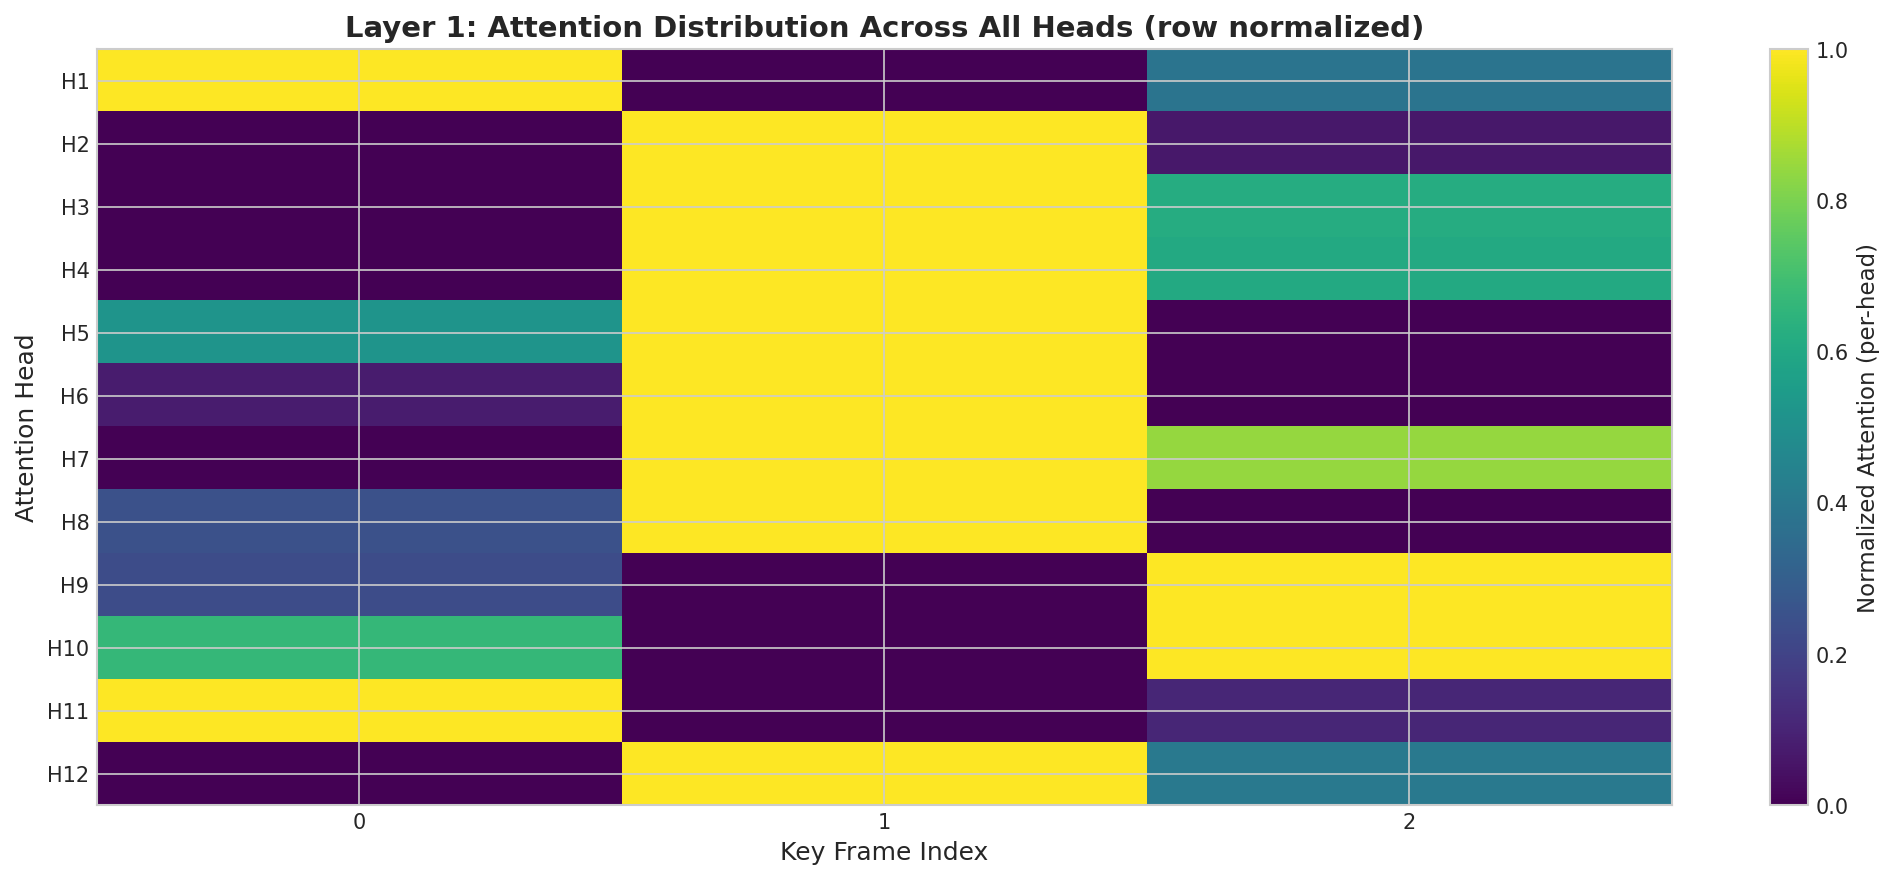


>>> Layer 1 热力图 (原始值):
原始值域: [-0.919115, 20.453667]
已保存到 figure4_layer1_all_heads_raw.svg


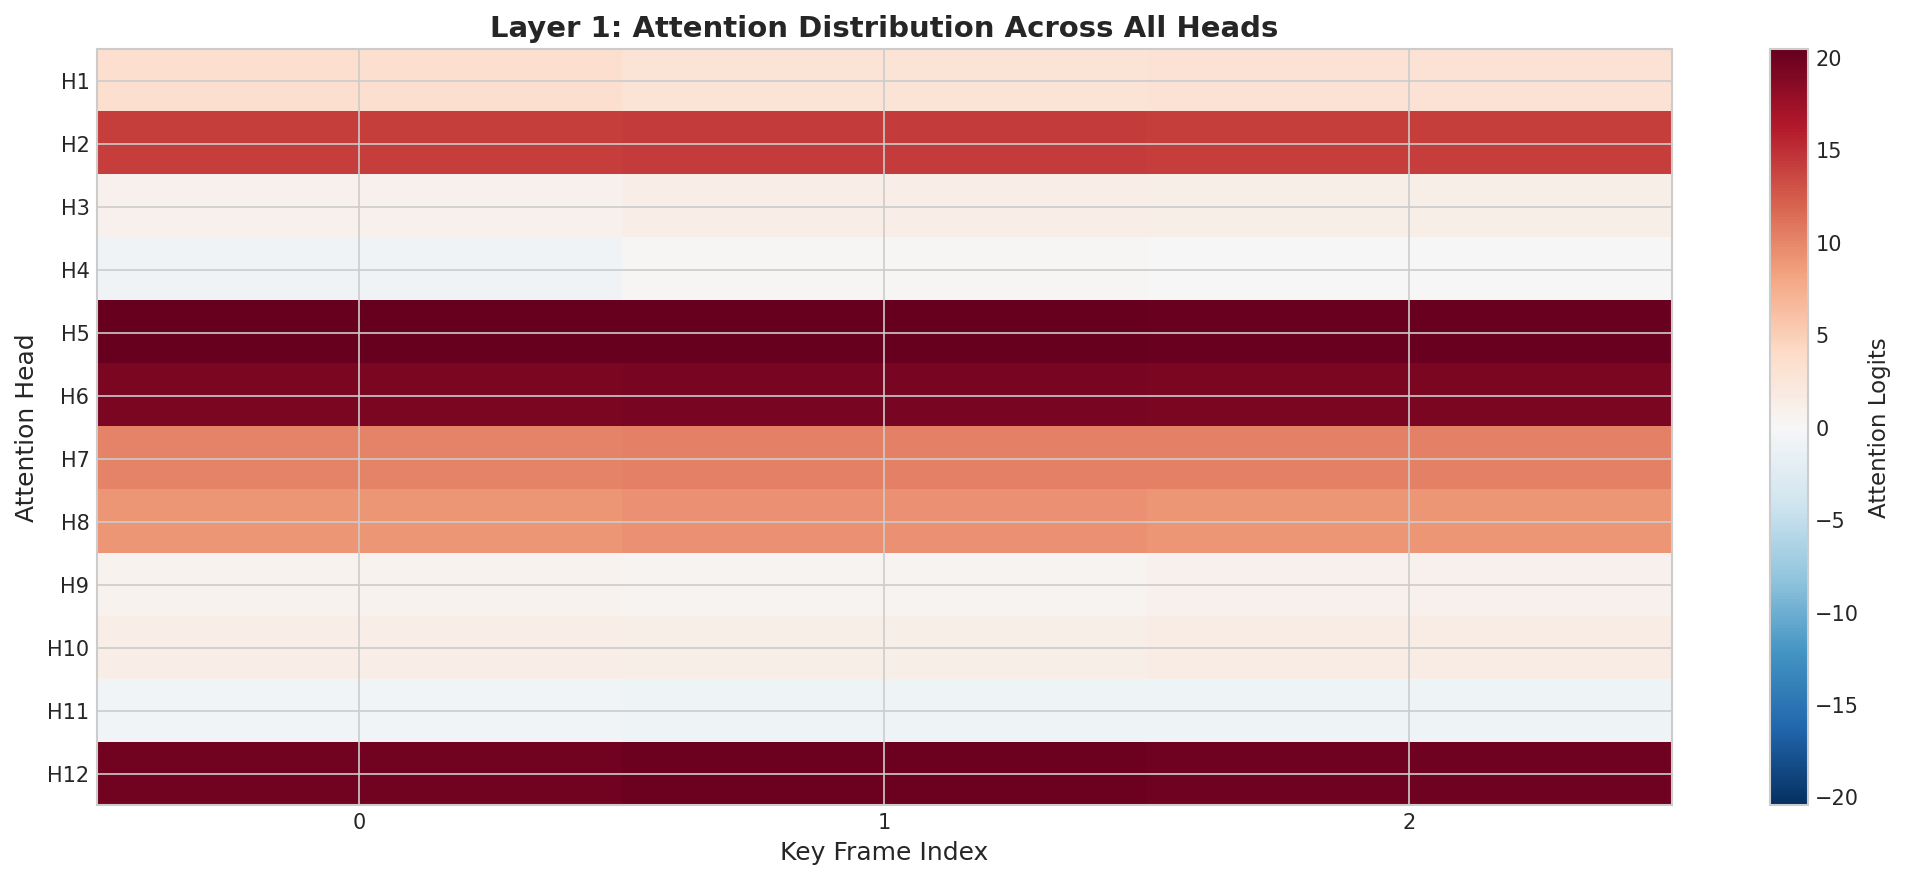


>>> Layer 5 热力图 (per-row normalized):
原始值域: [-1.025542, 12.693980]
应用 per-row 归一化以增强对比度
已保存到 figure4_layer5_all_heads.svg


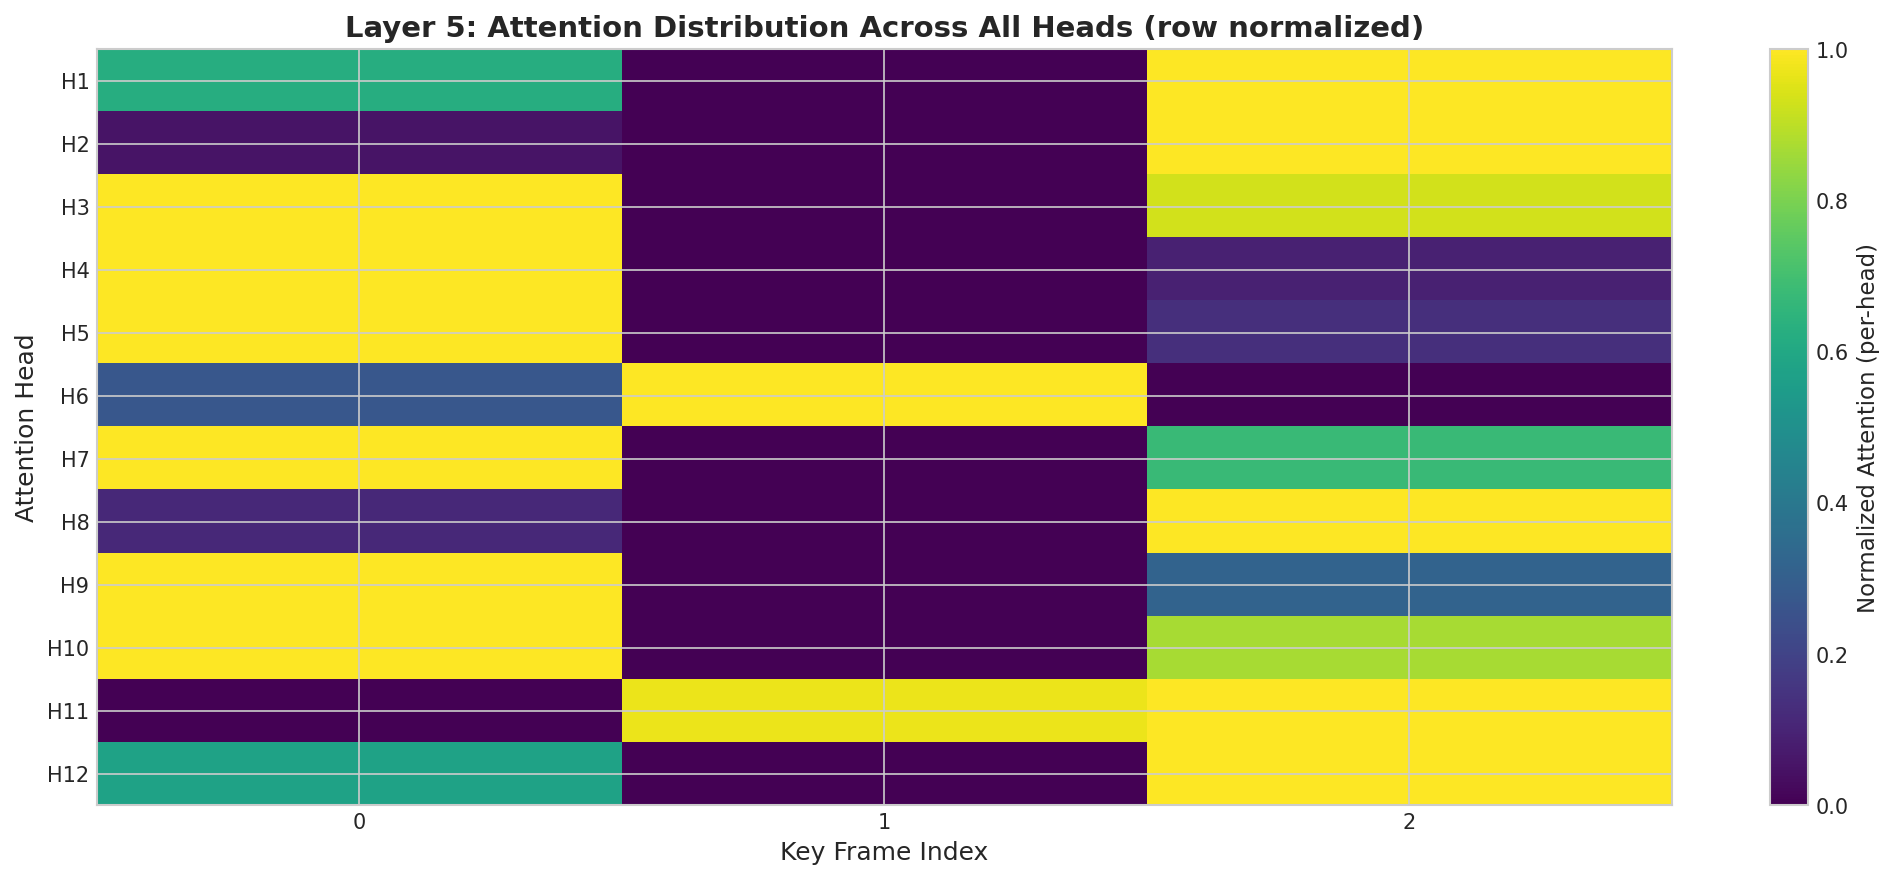


>>> Layer 5 热力图 (原始值):
原始值域: [-1.025542, 12.693980]
已保存到 figure4_layer5_all_heads_raw.svg


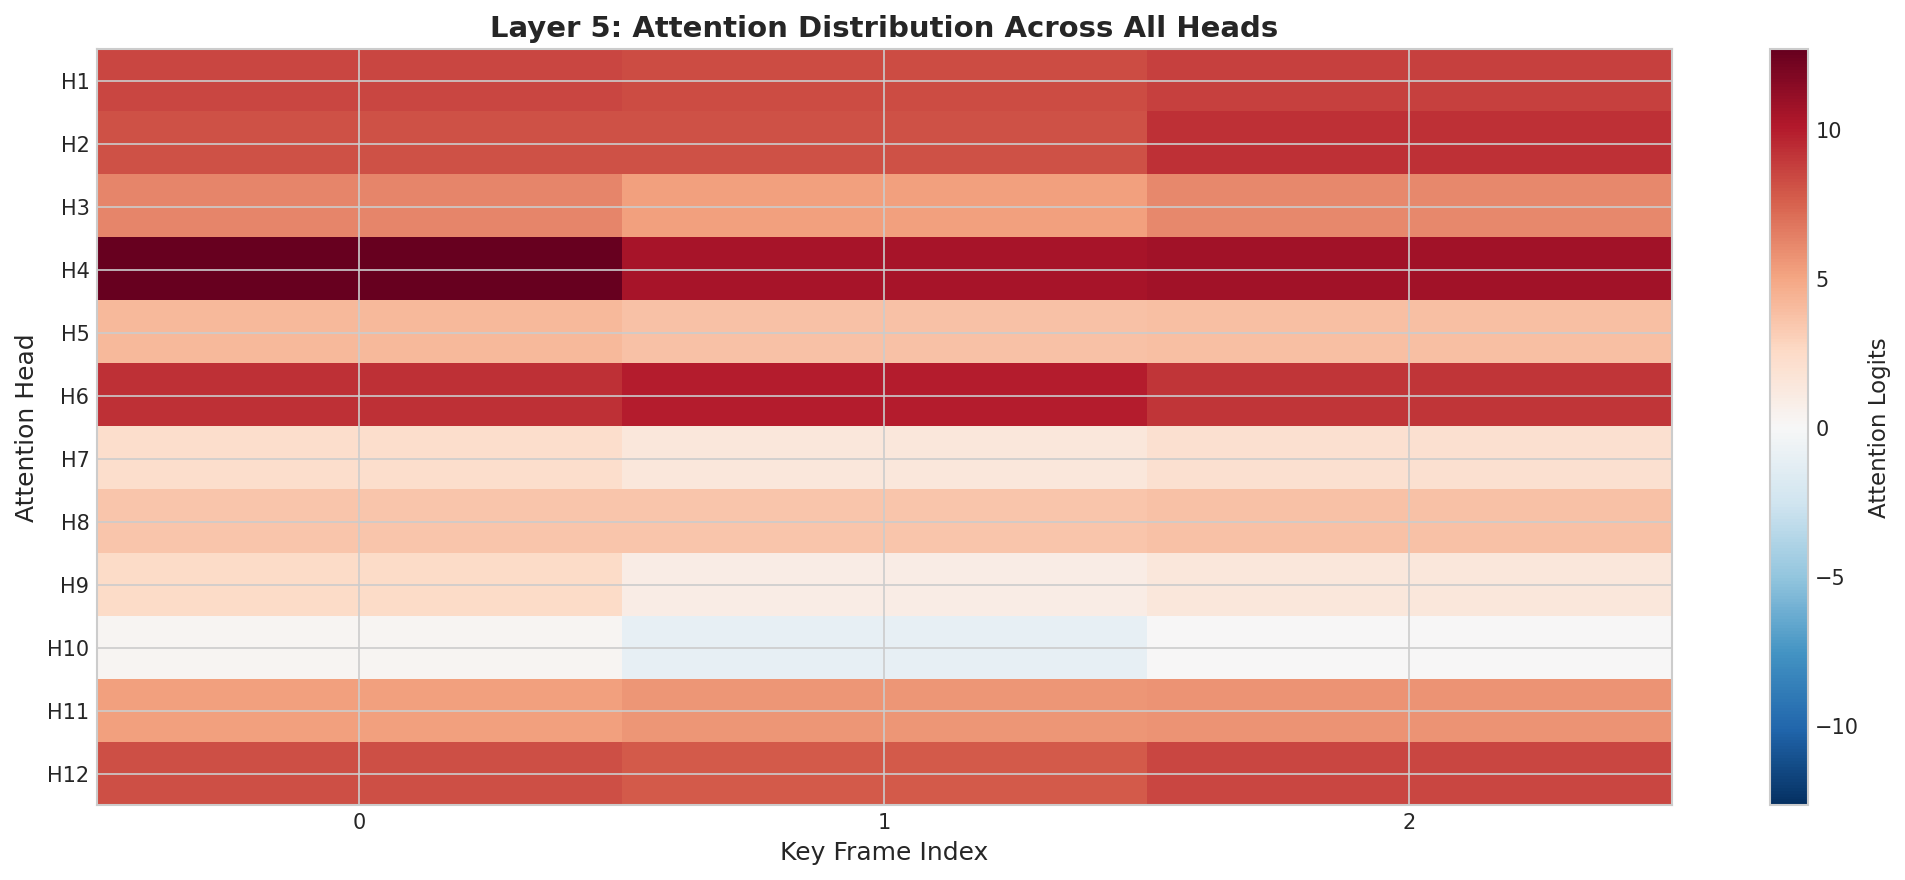

In [11]:
# 绘制所有 head 的热力图
# FIX: 使用 per-row 归一化增强颜色对比度

print("=" * 70)
print("热力图可视化（已修复颜色对比度）")
print("=" * 70)
print("normalize='row': 每个 head 独立归一化，突出各自的模式")
print("normalize='none': 原始值，适合比较绝对大小")
print("=" * 70)

# Layer 0 (L1) - 第 1 层
if 0 in layer_attention_data:
    print("\n>>> Layer 1 热力图 (per-row normalized):")
    fig = plot_all_heads_heatmap(
        layer_attention_data,
        layer_idx=0,
        save_path="figure4_layer1_all_heads.svg",
        normalize='row'  # 增强对比度
    )
    
    print("\n>>> Layer 1 热力图 (原始值):")
    fig = plot_all_heads_heatmap(
        layer_attention_data,
        layer_idx=0,
        save_path="figure4_layer1_all_heads_raw.svg",
        normalize='none'
    )

# Layer 4 (L5) - 第 5 层
if 4 in layer_attention_data:
    print("\n>>> Layer 5 热力图 (per-row normalized):")
    fig = plot_all_heads_heatmap(
        layer_attention_data,
        layer_idx=4,
        save_path="figure4_layer5_all_heads.svg",
        normalize='row'
    )
    
    print("\n>>> Layer 5 热力图 (原始值):")
    fig = plot_all_heads_heatmap(
        layer_attention_data,
        layer_idx=4,
        save_path="figure4_layer5_all_heads_raw.svg",
        normalize='none'
    )

## 4.5 FIX 2: Per-Head Grid 可视化（关键修复）

**问题**：之前的热力图可能掩盖了特定 head 的 "Deep Sink" 模式。
**修复**：为每个 head 单独绘制曲线图，形成 grid 布局，便于识别哪些 head 展现 U-shape 或 W-shape 模式。

In [12]:
def plot_per_head_grid(
    layer_attention_data: dict,
    layer_idx: int,
    save_path: str = None,
    figsize_per_head: tuple = (3, 2.5),
):
    """
    FIX 2: Per-Head Grid 可视化
    
    为单层的每个 head 单独绘制注意力分布曲线，形成 grid 布局。
    这样可以清晰看到哪些 head 展现 "Deep Sink"（U-shape 或 W-shape）模式。
    
    Args:
        layer_attention_data: 层索引 -> 注意力数据的字典
        layer_idx: 要可视化的层索引
        save_path: SVG 保存路径
        figsize_per_head: 每个子图的大小
    """
    if layer_idx not in layer_attention_data:
        print(f"Layer {layer_idx} 数据不存在！")
        return None

    data = layer_attention_data[layer_idx]
    frame_attention = data['frame_attention']  # [num_heads, num_frames]
    key_frame_indices = data['key_frame_indices']
    num_heads = frame_attention.shape[0]
    is_logits = data.get('is_logits', False)
    
    # 计算 grid 布局（尽量接近正方形）
    ncols = int(np.ceil(np.sqrt(num_heads)))
    nrows = int(np.ceil(num_heads / ncols))
    
    figsize = (figsize_per_head[0] * ncols, figsize_per_head[1] * nrows)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()
    
    # 颜色根据模式强度着色
    # 计算每个 head 的 "sink score" = 首帧/中间帧 的比值
    sink_scores = []
    for h in range(num_heads):
        head_attn = frame_attention[h]
        first = head_attn[0]
        middle = head_attn[1:-1].mean() if len(head_attn) > 2 else head_attn.mean()
        # 对于 logits，sink score 可以是负值也可以是正值
        sink_scores.append(first - middle if middle != 0 else 0)
    
    # 归一化 sink scores 用于颜色映射
    sink_scores = np.array(sink_scores)
    sink_min, sink_max = sink_scores.min(), sink_scores.max()
    if sink_max > sink_min:
        sink_norm = (sink_scores - sink_min) / (sink_max - sink_min)
    else:
        sink_norm = np.zeros_like(sink_scores)
    
    # 使用发散颜色映射：蓝色表示 sink，红色表示反 sink
    cmap = plt.cm.RdYlBu_r
    
    for h in range(num_heads):
        ax = axes[h]
        head_attn = frame_attention[h]
        color = cmap(sink_norm[h])
        
        # 绘制柱状图 + 折线图
        ax.bar(key_frame_indices, head_attn, color=color, alpha=0.6, width=0.8)
        ax.plot(key_frame_indices, head_attn, 'o-', color='black', 
                linewidth=1, markersize=2, alpha=0.7)
        
        # 标题显示 head 索引和 sink score
        title = f'H{h+1}'
        if is_logits:
            title += f' (Δ={sink_scores[h]:.2f})'
        ax.set_title(title, fontsize=9, fontweight='bold')
        
        # 简化 X 轴刻度
        if len(key_frame_indices) > 10:
            ax.set_xticks([0, len(key_frame_indices)//2, len(key_frame_indices)-1])
        
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax.grid(True, alpha=0.3, linestyle='--')
        
        # 标注首帧和末帧值
        ax.axhline(y=head_attn[0], color='red', linestyle=':', alpha=0.5, linewidth=0.8)
        
        # Y 轴标签只显示在最左列
        if h % ncols == 0:
            ylabel = 'Logits' if is_logits else 'Prob'
            ax.set_ylabel(ylabel, fontsize=8)
    
    # 隐藏未使用的子图
    for h in range(num_heads, len(axes)):
        axes[h].set_visible(False)
    
    # 总标题
    data_type = 'Pre-Softmax Logits' if is_logits else 'Post-Softmax Probs'
    fig.suptitle(
        f'FIX 2: Layer {layer_idx + 1} - Per-Head Attention Distribution Grid\n'
        f'({data_type}, Δ = First Frame - Middle Frames Average)',
        fontsize=12, fontweight='bold', y=1.02
    )
    
    plt.tight_layout()
    
    # 保存为高质量 SVG
    if save_path:
        svg_path = save_path if save_path.endswith('.svg') else save_path.replace('.png', '.svg')
        plt.savefig(svg_path, format='svg', bbox_inches='tight',
                    metadata={'Creator': 'Self-Forcing Figure 4 - Per-Head Grid'})
        print(f"已保存到 {svg_path}")
    
    plt.show()
    
    # 打印 sink score 排名
    print(f"\nLayer {layer_idx + 1} - Head Sink Score 排名（从高到低）：")
    print("（正值 = 首帧注意力高于中间帧 = Attention Sink 模式）")
    print("-" * 50)
    sorted_indices = np.argsort(sink_scores)[::-1]
    for rank, h in enumerate(sorted_indices[:5]):  # Top 5
        print(f"  #{rank+1}: H{h+1}, Δ = {sink_scores[h]:.4f}")
    print("...")
    for rank, h in enumerate(sorted_indices[-3:]):  # Bottom 3
        print(f"  #{num_heads - 2 + rank}: H{h+1}, Δ = {sink_scores[h]:.4f}")
    
    return fig

FIX 2: Per-Head Grid 可视化
每个子图显示一个 head 的注意力分布曲线
Δ = 首帧注意力 - 中间帧平均注意力
正 Δ 表示 Attention Sink 模式，负 Δ 表示反向模式

>>> Layer 1 Per-Head Grid:
已保存到 figure4_layer1_per_head_grid.svg


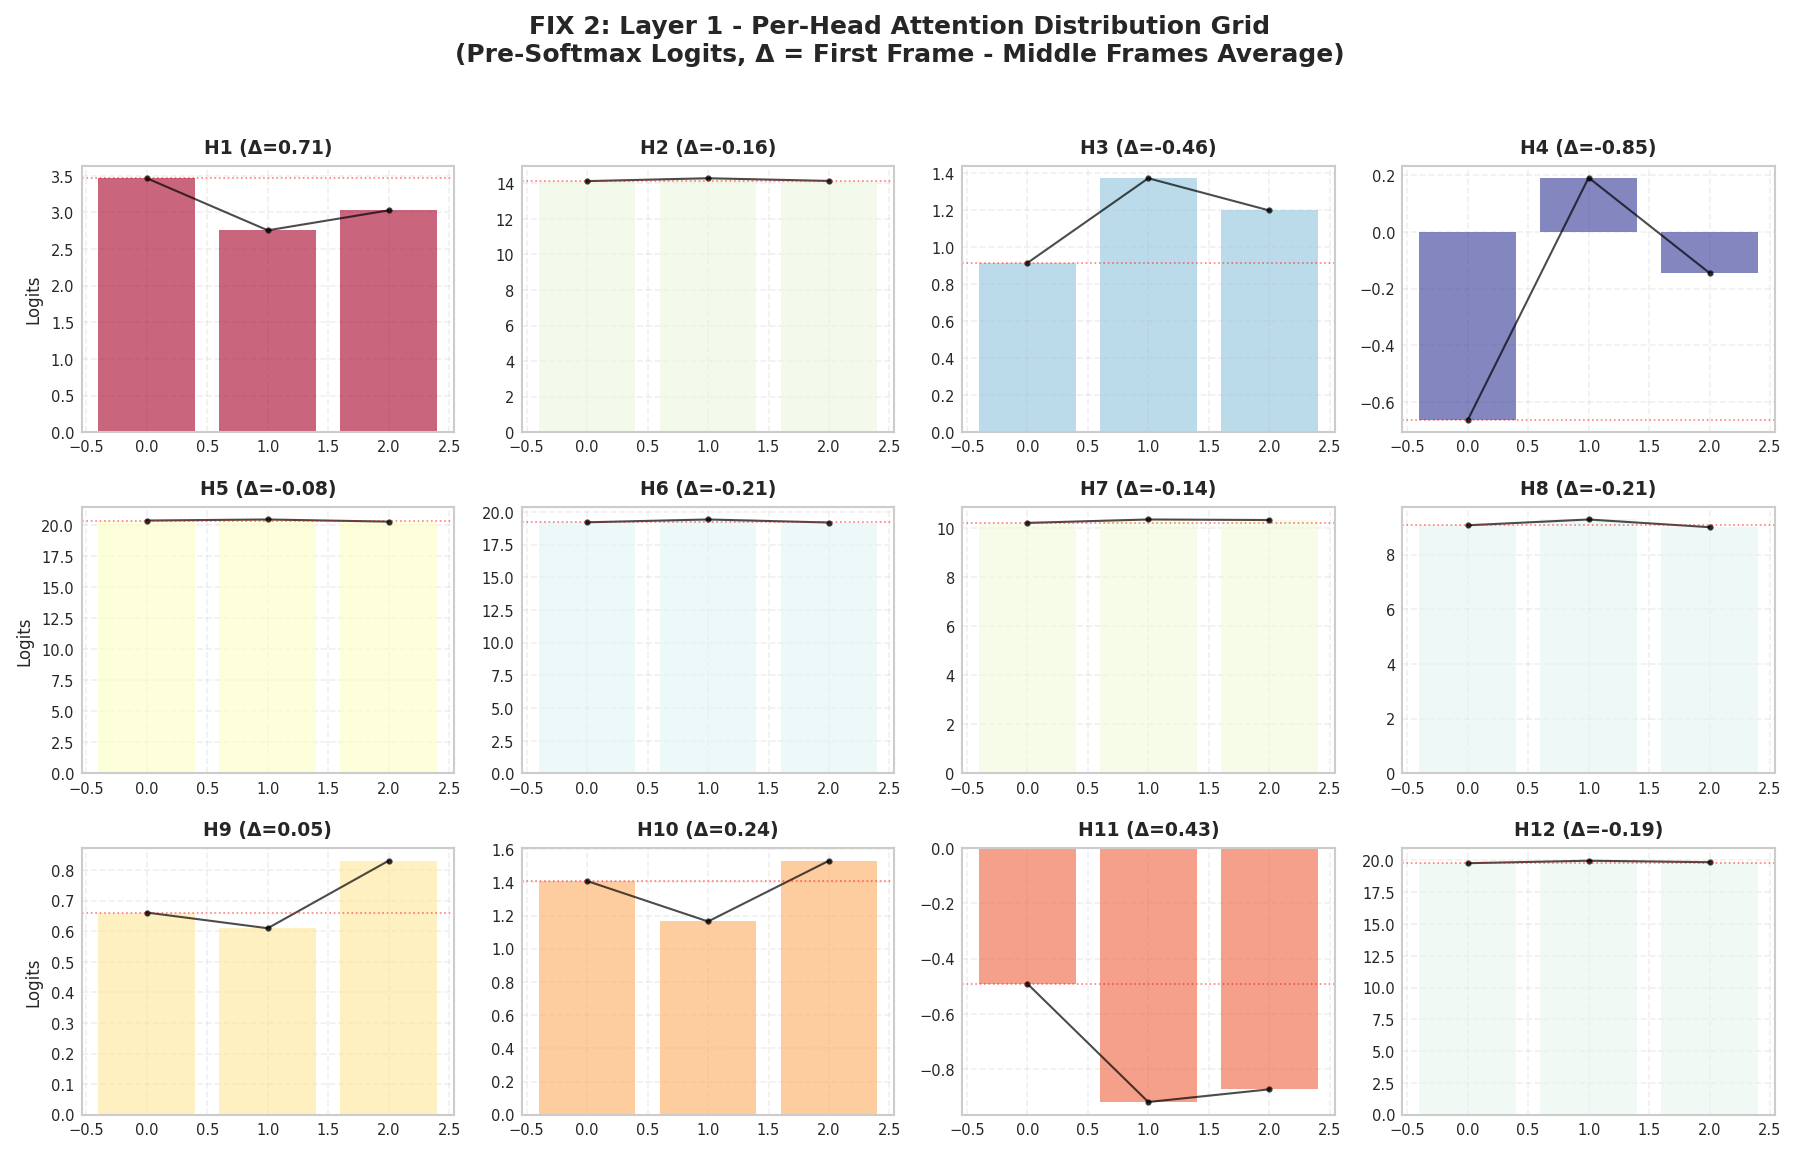


Layer 1 - Head Sink Score 排名（从高到低）：
（正值 = 首帧注意力高于中间帧 = Attention Sink 模式）
--------------------------------------------------
  #1: H1, Δ = 0.7109
  #2: H11, Δ = 0.4280
  #3: H10, Δ = 0.2437
  #4: H9, Δ = 0.0513
  #5: H5, Δ = -0.0838
...
  #10: H6, Δ = -0.2144
  #11: H3, Δ = -0.4576
  #12: H4, Δ = -0.8542

>>> Layer 5 Per-Head Grid:
已保存到 figure4_layer5_per_head_grid.svg


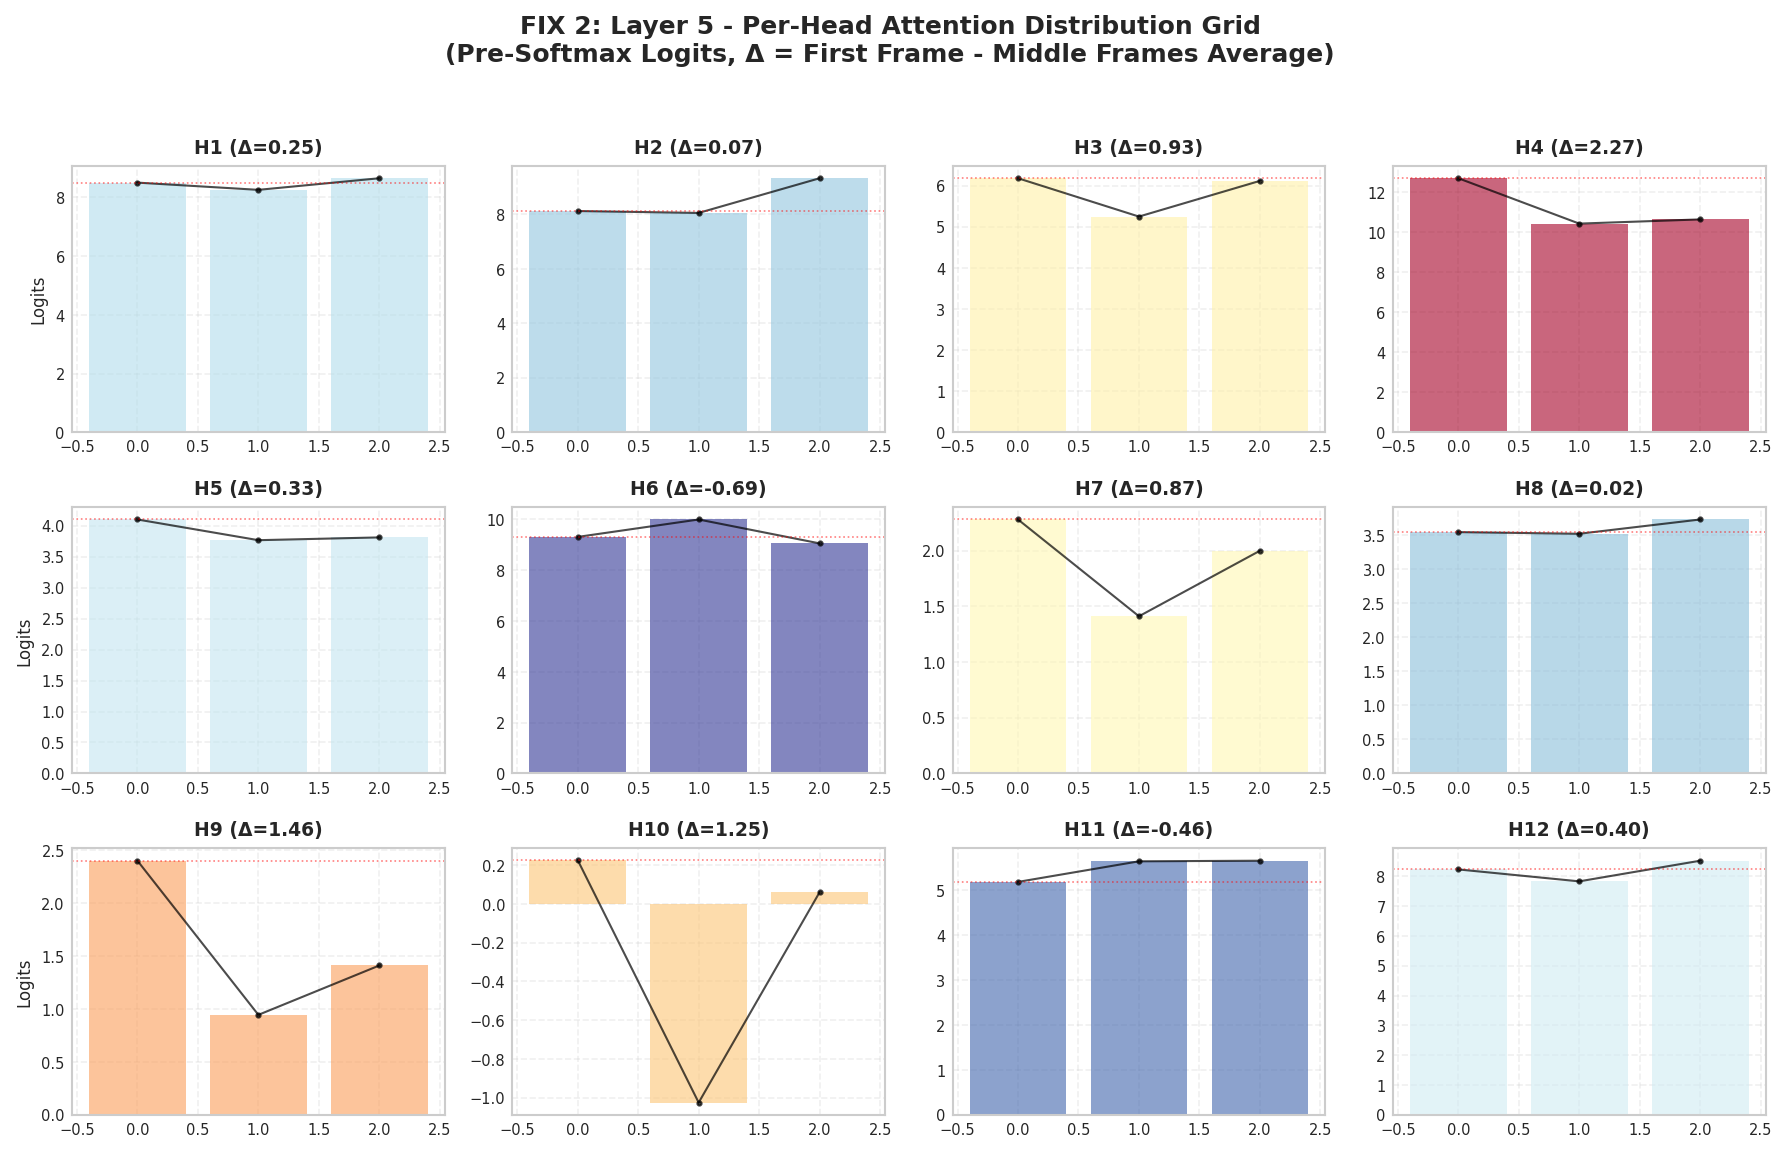


Layer 5 - Head Sink Score 排名（从高到低）：
（正值 = 首帧注意力高于中间帧 = Attention Sink 模式）
--------------------------------------------------
  #1: H4, Δ = 2.2672
  #2: H9, Δ = 1.4583
  #3: H10, Δ = 1.2516
  #4: H3, Δ = 0.9323
  #5: H7, Δ = 0.8684
...
  #10: H8, Δ = 0.0241
  #11: H11, Δ = -0.4589
  #12: H6, Δ = -0.6858


In [13]:
# FIX 2: 绘制 Per-Head Grid 可视化
# 这是关键修复：可以清晰看到每个 head 的独立模式

print("=" * 70)
print("FIX 2: Per-Head Grid 可视化")
print("=" * 70)
print("每个子图显示一个 head 的注意力分布曲线")
print("Δ = 首帧注意力 - 中间帧平均注意力")
print("正 Δ 表示 Attention Sink 模式，负 Δ 表示反向模式")
print("=" * 70)

# Layer 0 (L1) - 第 1 层
if 0 in layer_attention_data:
    print("\n>>> Layer 1 Per-Head Grid:")
    fig = plot_per_head_grid(
        layer_attention_data,
        layer_idx=0,
        save_path="figure4_layer1_per_head_grid.svg"
    )

# Layer 4 (L5) - 第 5 层
if 4 in layer_attention_data:
    print("\n>>> Layer 5 Per-Head Grid:")
    fig = plot_per_head_grid(
        layer_attention_data,
        layer_idx=4,
        save_path="figure4_layer5_per_head_grid.svg"
    )

## 5. 跨层注意力对比

比较不同层之间 head 平均注意力分布的差异，验证论文的核心发现。

In [14]:
def plot_attention_comparison(
    layer_attention_data: dict,
    layers_to_compare: list = None,
    save_path: str = None,
    figsize: tuple = (14, 5),
):
    """
    比较不同层的 head 平均注意力分布。
    验证论文的观点：注意力分布在整个上下文窗口中，而不仅仅集中在初始帧。
    图中 label 全部使用英文。
    """
    if layers_to_compare is None:
        layers_to_compare = sorted(layer_attention_data.keys())

    fig, ax = plt.subplots(figsize=figsize)

    colors = plt.cm.viridis(np.linspace(0, 1, len(layers_to_compare)))

    for idx, layer_idx in enumerate(layers_to_compare):
        if layer_idx not in layer_attention_data:
            continue

        data = layer_attention_data[layer_idx]
        frame_attention = data['frame_attention']
        key_frame_indices = data['key_frame_indices']

        # 对所有 head 求平均
        mean_attention = frame_attention.mean(axis=0)
        std_attention = frame_attention.std(axis=0)

        color = colors[idx]
        ax.plot(key_frame_indices, mean_attention, 'o-',
               color=color, linewidth=2, markersize=5,
               label=f'Layer {layer_idx + 1}', alpha=0.8)
        ax.fill_between(key_frame_indices,
                       mean_attention - std_attention,
                       mean_attention + std_attention,
                       color=color, alpha=0.2)

    # 英文标签
    ax.set_xlabel('Key Frame Index', fontsize=12)
    ax.set_ylabel('Mean Attention Weight', fontsize=12)
    ax.set_title('Cross-Layer Head-Averaged Attention Distribution',
                fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')

    plt.tight_layout()

    # 保存为高质量 SVG
    if save_path:
        svg_path = save_path if save_path.endswith('.svg') else save_path.replace('.png', '.svg')
        plt.savefig(svg_path, format='svg', bbox_inches='tight',
                    metadata={'Creator': 'Self-Forcing Figure 4 Reproduction'})
        print(f"已保存到 {svg_path}")

    plt.show()
    return fig

已保存到 figure4_layer_comparison.svg


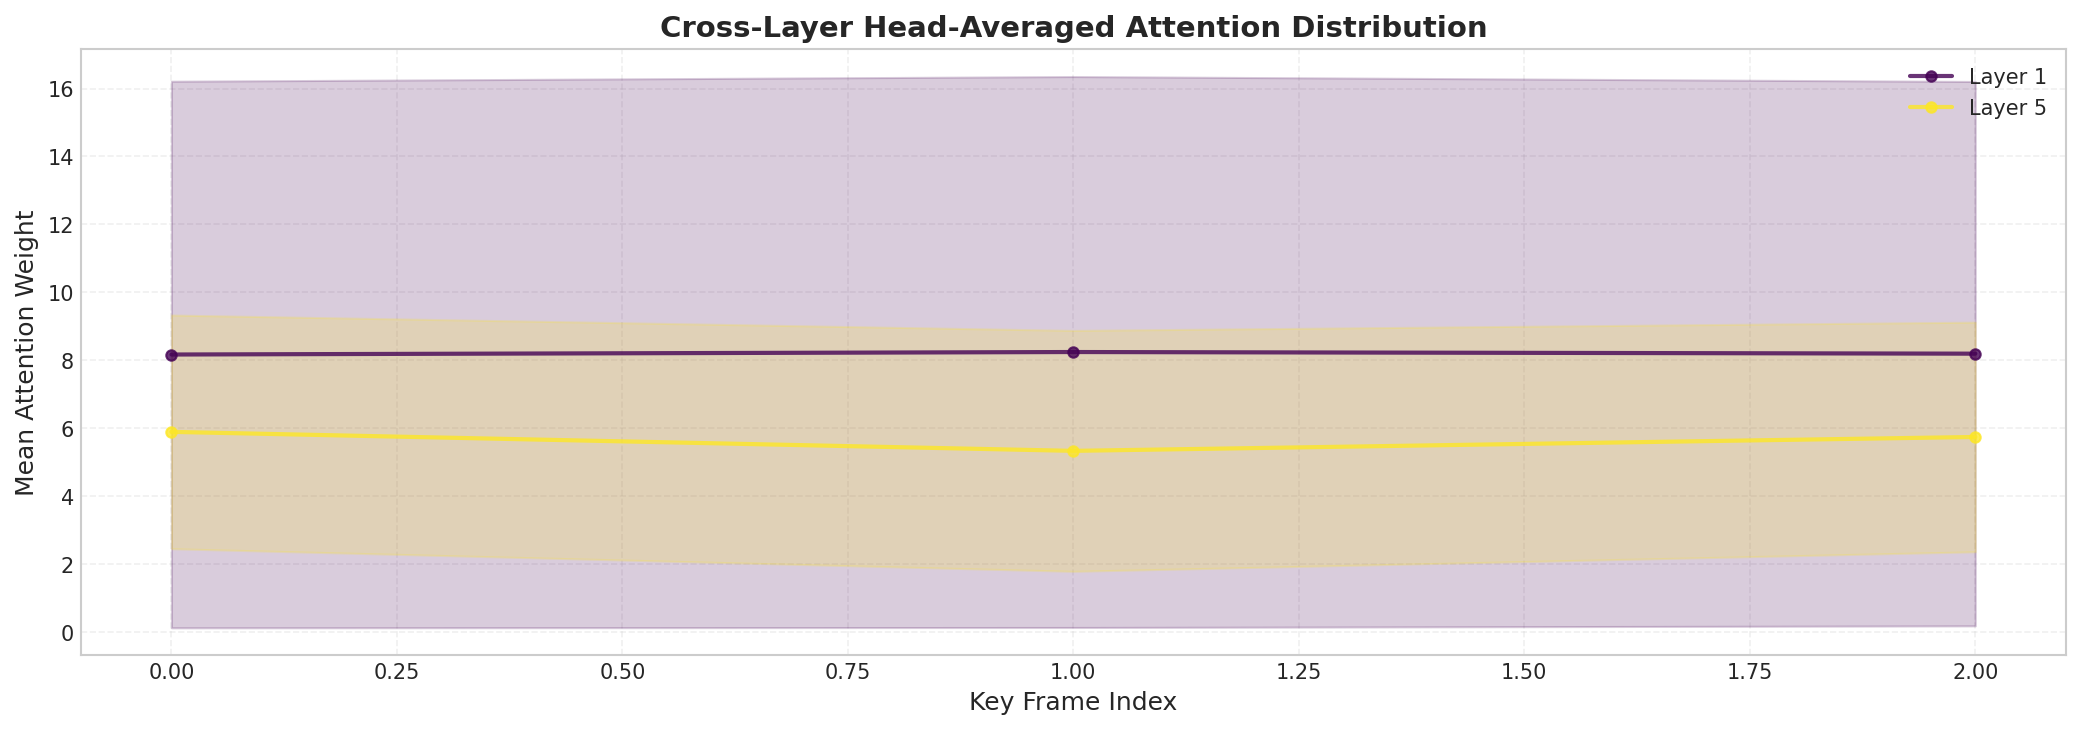

In [15]:
# 跨层注意力分布对比
fig = plot_attention_comparison(
    layer_attention_data,
    layers_to_compare=sorted(layer_attention_data.keys()),
    save_path="figure4_layer_comparison.svg"
)

## 6. 统计分析

验证论文的核心发现：注意力分布在整个上下文窗口中，而不仅仅集中在初始帧。

In [16]:
def plot_attention_statistics(layer_attention_data: dict, save_path: str = None):
    """
    输出注意力分布的统计信息并可视化。
    验证论文的核心发现：注意力分布在整个上下文窗口中。
    图中 label 全部使用英文。
    """
    print("=" * 70)
    print("注意力分析摘要 (Figure 4 复现)")
    print("=" * 70)

    # 收集统计数据
    stats_data = []

    for layer_idx in sorted(layer_attention_data.keys()):
        data = layer_attention_data[layer_idx]
        frame_attention = data['frame_attention']
        key_frame_indices = data['key_frame_indices']
        num_frames = len(key_frame_indices)

        if num_frames < 3:
            continue

        # Head 平均注意力
        mean_attn = frame_attention.mean(axis=0)

        # 统计量
        first_frame_attn = mean_attn[0]
        last_frame_attn = mean_attn[-1]
        middle_attn = mean_attn[1:-1].mean() if len(mean_attn) > 2 else mean_attn.mean()
        max_frame = np.argmax(mean_attn)
        min_frame = np.argmin(mean_attn)

        stats_data.append({
            'layer': layer_idx + 1,
            'first': first_frame_attn,
            'middle': middle_attn,
            'last': last_frame_attn,
            'max_frame': max_frame,
            'min_frame': min_frame,
            'ratio_first_middle': first_frame_attn / middle_attn if middle_attn > 0 else 0,
        })

        print(f"\nLayer {layer_idx + 1} (Key 帧数: {num_frames}):")
        print(f"  首帧注意力:   {first_frame_attn:.6f}")
        print(f"  中间帧注意力: {middle_attn:.6f}")
        print(f"  末帧注意力:   {last_frame_attn:.6f}")
        print(f"  最大注意力帧: {max_frame}")
        print(f"  首帧/中间比:  {first_frame_attn/middle_attn:.2f}x" if middle_attn > 0 else "  首帧/中间比: N/A")

    print("\n" + "=" * 70)
    print("论文的关键发现：")
    print("  '大多数注意力头不仅对最早的 token 分配了大量权重，")
    print("   还对序列中间部分分配了相当的注意力。'")
    print("=" * 70)

    # 绘制统计可视化
    if len(stats_data) > 0:
        fig, ax = plt.subplots(figsize=(10, 5))

        layers = [s['layer'] for s in stats_data]
        first_attns = [s['first'] for s in stats_data]
        middle_attns = [s['middle'] for s in stats_data]
        last_attns = [s['last'] for s in stats_data]

        x = np.arange(len(layers))
        width = 0.25

        ax.bar(x - width, first_attns, width, label='First Frame', color='#2E86AB')
        ax.bar(x, middle_attns, width, label='Middle Frames', color='#F18F01')
        ax.bar(x + width, last_attns, width, label='Last Frame', color='#A23B72')

        # 英文标签
        ax.set_xlabel('Layer', fontsize=12)
        ax.set_ylabel('Mean Attention Weight', fontsize=12)
        ax.set_title('Attention Distribution: First vs Middle vs Last Frame',
                    fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([f'L{l}' for l in layers])
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()

        # 保存为高质量 SVG
        if save_path:
            svg_path = save_path if save_path.endswith('.svg') else save_path.replace('.png', '.svg')
            plt.savefig(svg_path, format='svg', bbox_inches='tight',
                        metadata={'Creator': 'Self-Forcing Figure 4 Reproduction'})
            print(f"\n已保存到 {svg_path}")

        plt.show()
        return fig

    return None

注意力分析摘要 (Figure 4 复现)

Layer 1 (Key 帧数: 3):
  首帧注意力:   8.173216
  中间帧注意力: 8.246714
  末帧注意力:   8.198456
  最大注意力帧: 1
  首帧/中间比:  0.99x

Layer 5 (Key 帧数: 3):
  首帧注意力:   5.897503
  中间帧注意力: 5.338543
  末帧注意力:   5.747517
  最大注意力帧: 0
  首帧/中间比:  1.10x

论文的关键发现：
  '大多数注意力头不仅对最早的 token 分配了大量权重，
   还对序列中间部分分配了相当的注意力。'

已保存到 figure4_statistics.svg


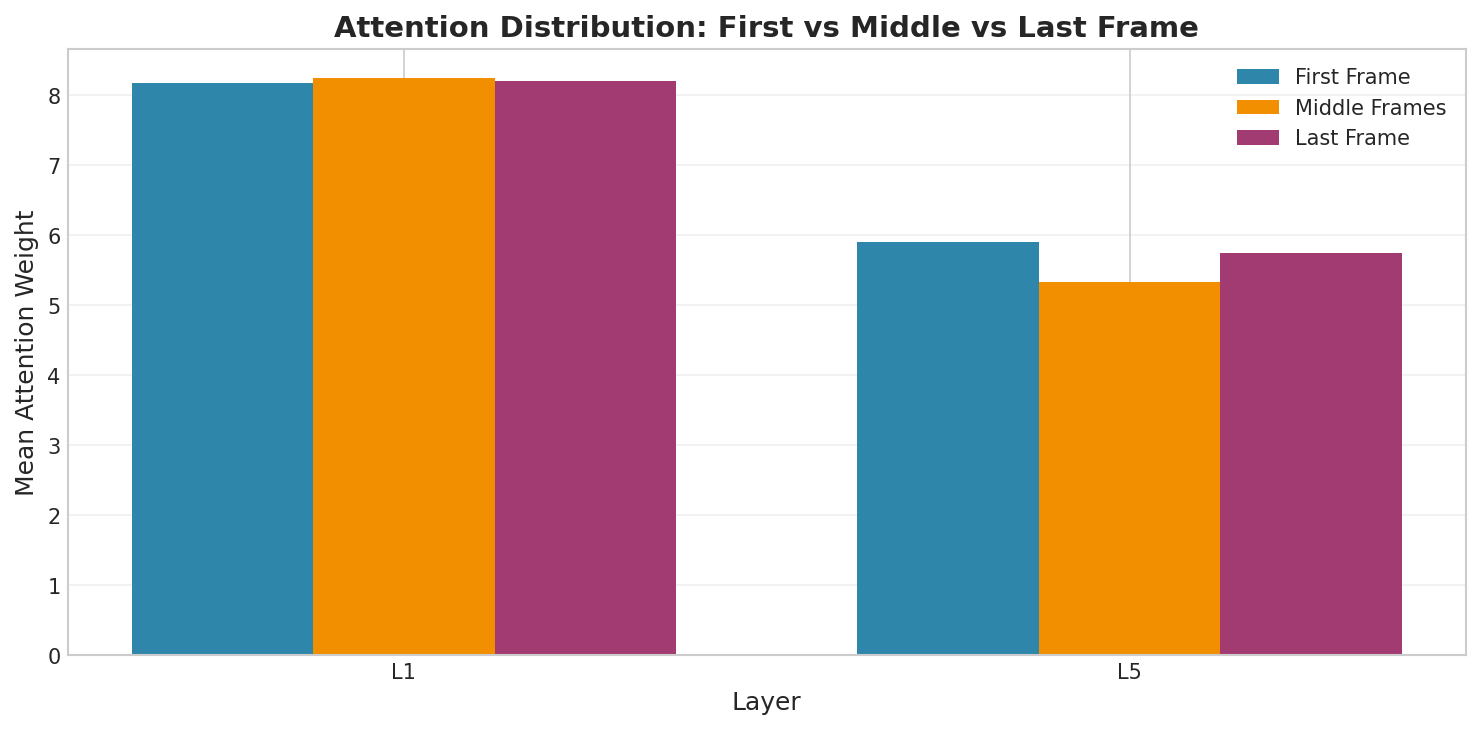

In [17]:
# 生成统计分析和可视化
fig = plot_attention_statistics(layer_attention_data, save_path="figure4_statistics.svg")

print("=" * 70)
print("FIGURE 4 复现完成")
print("=" * 70)
print(f"\nPrompt: {data.get('prompt', 'N/A')}")
print(f"帧数: {data.get('num_frames', 'N/A')}")
print(f"每 block 帧数: {data.get('num_frame_per_block', 'N/A')}")
print(f"\n捕获的层: {list(layer_attention_data.keys())}")

# FIX 1 验证：检查是否为 pre-softmax logits
print("\n" + "-" * 70)
print("FIX 1 验证：Pre-Softmax Logits 检查")
print("-" * 70)
is_logits = data.get('is_logits', False)
if is_logits:
    print("  ✓ 数据标记为 pre-softmax logits")
else:
    print("  ⚠ 数据未标记为 logits，可能是旧格式")

# 检查实际值域
for layer_idx, layer_data in layer_attention_data.items():
    attn = layer_data['frame_attention']
    min_val, max_val = attn.min(), attn.max()
    print(f"  Layer {layer_idx}: 值域 [{min_val:.4f}, {max_val:.4f}]")
    if min_val < 0:
        print(f"    ✓ 检测到负值，确认是 pre-softmax logits！")
    elif max_val <= 1.0 and min_val >= 0:
        print(f"    ⚠ 值域在 [0,1]，可能是 post-softmax probs")
        print(f"    请重新运行: python run_extraction_figure4.py")

print("\n" + "-" * 70)
print("生成的高质量 SVG 文件（图中 label 均为英文）：")
print("-" * 70)
print("  - figure4_reproduction.svg        : 主 Figure 4 (L1H1 和 L5H10)")
print("  - figure4_layer1_all_heads.svg    : Layer 1 所有 head 热力图")
print("  - figure4_layer5_all_heads.svg    : Layer 5 所有 head 热力图")
print("  - figure4_layer1_per_head_grid.svg: Layer 1 Per-Head Grid (FIX 2)")
print("  - figure4_layer5_per_head_grid.svg: Layer 5 Per-Head Grid (FIX 2)")
print("  - figure4_layer_comparison.svg    : 跨层对比")
print("  - figure4_statistics.svg          : 统计摘要")
print("-" * 70)

print("\n" + "=" * 70)
print("三项修复说明：")
print("=" * 70)
print("""
FIX 1: 捕获 Pre-Softmax Logits（关键）
  - 问题：之前捕获的是 softmax 后的概率 [0,1]
  - 修复：现在捕获 Q*K^T/sqrt(d) 的原始分数（可以是负值）
  - 论文 Y 轴范围 [-4, 6] 证明使用的是 logits

FIX 2: 不平均所有 Heads
  - 问题：平均所有 head 会掩盖特定 head 的 "Deep Sink" 模式
  - 修复：新增 Per-Head Grid 可视化，每个 head 单独绘图
  - 可通过 Δ 值（首帧-中间帧）识别 sink head

FIX 3: 时序 vs 空间注意力验证
  - 在提取脚本中添加了验证打印
  - Key_Len 应等于 num_frames × tokens_per_frame
  - 如果 Key_Len 很大（如 4096），则是空间注意力
""")

print("\n" + "=" * 70)
print("如果图仍然是平坦分布，请重新运行提取脚本：")
print("=" * 70)
print("""
python run_extraction_figure4.py \\
    --config_path configs/self_forcing_dmd.yaml \\
    --checkpoint_path checkpoints/self_forcing_dmd.pt \\
    --output_path attention_cache_figure4.pt \\
    --layer_indices 0 4 \\
    --use_ema
""")

In [18]:
print("=" * 70)
print("FIGURE 4 复现完成")
print("=" * 70)
print(f"\nPrompt: {data.get('prompt', 'N/A')}")
print(f"帧数: {data.get('num_frames', 'N/A')}")
print(f"每 block 帧数: {data.get('num_frame_per_block', 'N/A')}")
print(f"\n捕获的层: {list(layer_attention_data.keys())}")

print("\n" + "-" * 70)
print("生成的高质量 SVG 文件（图中 label 均为英文）：")
print("-" * 70)
print("  - figure4_reproduction.svg     : 主 Figure 4 (L1H1 和 L5H10)")
print("  - figure4_layer1_all_heads.svg : Layer 1 所有 head 热力图")
print("  - figure4_layer5_all_heads.svg : Layer 5 所有 head 热力图")
print("  - figure4_layer_comparison.svg : 跨层对比")
print("  - figure4_statistics.svg       : 统计摘要")
print("-" * 70)

print("\n" + "=" * 70)
print("论文的关键观察：")
print("=" * 70)
print("""
'与传统理解（认为只需保留少量初始 KV token）不同，我们的分析揭示：
大多数注意力头不仅对最早的 token 分配了大量权重，还对序列中间部分
分配了相当的注意力。'

这一发现表明：对于自回归视频生成，需要保留完整的上下文，而不是像
LLM 中常用的 attention sink 机制那样只保留初始 token 和最近 token。
""")

FIGURE 4 复现完成

Prompt: A majestic eagle soaring through a cloudy sky, cinematic lighting
帧数: 21
每 block 帧数: 3

捕获的层: [0, 4]

----------------------------------------------------------------------
生成的高质量 SVG 文件（图中 label 均为英文）：
----------------------------------------------------------------------
  - figure4_reproduction.svg     : 主 Figure 4 (L1H1 和 L5H10)
  - figure4_layer1_all_heads.svg : Layer 1 所有 head 热力图
  - figure4_layer5_all_heads.svg : Layer 5 所有 head 热力图
  - figure4_layer_comparison.svg : 跨层对比
  - figure4_statistics.svg       : 统计摘要
----------------------------------------------------------------------

论文的关键观察：

'与传统理解（认为只需保留少量初始 KV token）不同，我们的分析揭示：
大多数注意力头不仅对最早的 token 分配了大量权重，还对序列中间部分
分配了相当的注意力。'

这一发现表明：对于自回归视频生成，需要保留完整的上下文，而不是像
LLM 中常用的 attention sink 机制那样只保留初始 token 和最近 token。



## 8. 技术说明

### Figure 4 结果解读

**论文的关键发现：**
> "与传统理解（认为只需保留少量初始 KV token）不同，我们的分析揭示：
> 大多数注意力头不仅对最早的 token 分配了大量权重，还对序列中间部分分配了相当的注意力。"

### 这意味着什么：

1. **不仅仅是 Attention Sink**：与 LLM 中注意力通常集中在初始 token（attention sink 模式）不同，
   视频扩散模型的注意力在所有帧之间分布更均匀。

2. **完整上下文很重要**：对于自回归视频生成，保留完整的 KV cache 很重要——
   不仅仅是前几帧和最近的帧。

3. **层间差异**：不同层可能表现出不同的注意力模式。

### 技术细节：

- **Query**：最后一个 chunk（21 帧视频中的第 19-21 帧）
- **Key**：之前的 KV cache 条目（第 0-18 帧）
- **注意力形状**：`[B, num_heads, Lq, Lk]`
- **每帧 token 数**：1560 tokens（60×104 / 4 patches）

### SVG 输出配置：

- `svg.fonttype: none` - 使用真实字体而非路径，确保文字可编辑
- `savefig.dpi: 300` - 高分辨率输出
- 所有图中 label 使用英文，确保跨平台兼容性

In [19]:
# 空单元格 - notebook 结束